In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

In [3]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = graph.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    graph.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

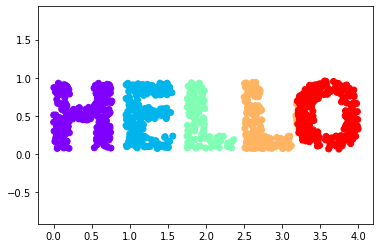

In [6]:
X = make_hello(1000)
colorize = dict(c = X[:, 0], cmap = graph.cm.get_cmap('rainbow', 5))

graph.scatter(X[:, 0], X[:, 1], **colorize)
graph.axis('equal')
graph.show()

# Multidimensional scaling

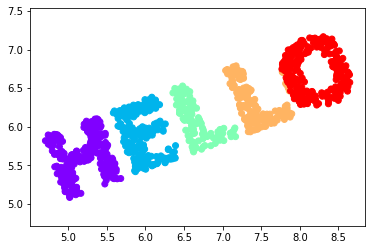

In [7]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    
    R = [[np.cos(theta), np.sin(theta)], 
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5

graph.scatter(X2[:, 0], X2[:, 1], **colorize)
graph.axis('equal')
graph.show()

So what actually counts here are the distances between the points, rather than the relationship between x and y

In [8]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X)
D.shape

(1000, 1000)

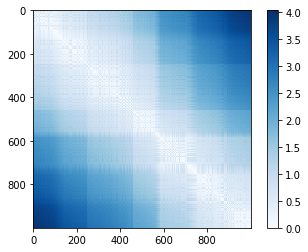

In [9]:
graph.imshow(D, zorder=2, cmap="Blues", interpolation="nearest")
graph.colorbar()
graph.show()

This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data

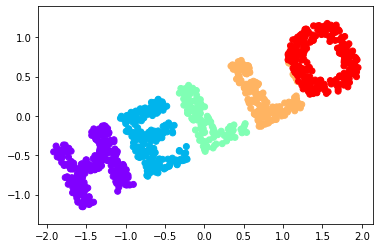

In [10]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

graph.scatter(out[:, 0], out[:, 1], **colorize)
graph.axis('equal')
graph.show()

# MDS as Manifold Learning

In [12]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.rand(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

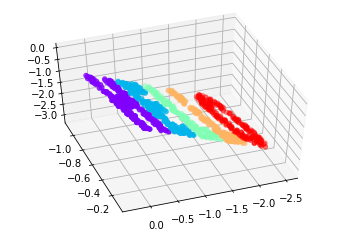

In [13]:
from mpl_toolkits import mplot3d

ax = graph.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)
graph.show()

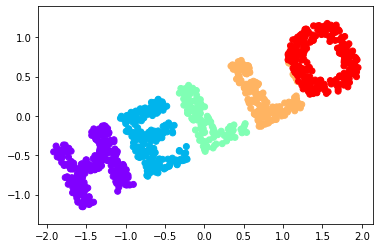

In [14]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)

graph.scatter(out3[:, 0], out3[:, 1], **colorize)
graph.axis('equal')
graph.show()

# Non linear Embeddings: Where MDS failes

In [15]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

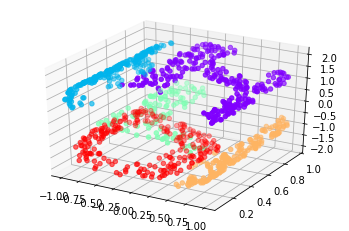

In [16]:
ax = graph.axes(projection = '3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)
graph.show()

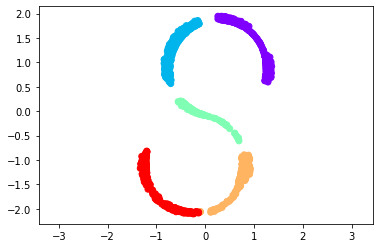

In [17]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)

graph.scatter(outS[:, 0], outS[:, 1], **colorize)
graph.axis('equal')
graph.show()

# Nonlinear Manifolds: Locally Linear Embedding <br>
This keeps only distance between nearby points

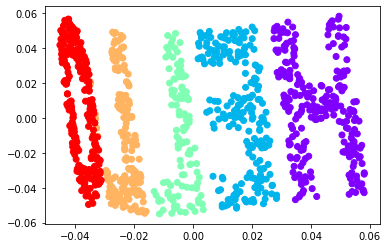

In [25]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

graph.scatter(out[:, 0], out[:, 1], **colorize)
graph.show()

Issues with manifold learning, compared to PCA: <br>
- No framework to handle missing data in manifold, but good approaches in PCA
- noise can affect manifold learning drastically, pca naturally filters out noise
- manifold embedding highly dependent on neighboirs chosen
- in manifold, # optimum output is hard to determin
- computational expence scale as O[N^2] or O[N^3]

But advantage over PCA is that they can preserve non linear relationships.

- For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap
- For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE

# Example: ISOmap on faces

In [26]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

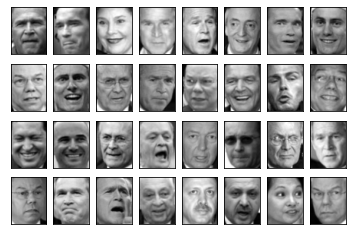

In [27]:
fig, ax = graph.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

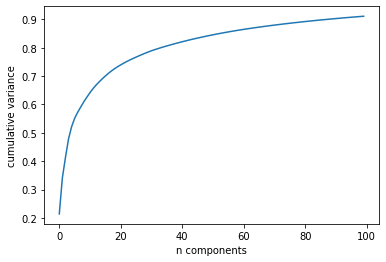

In [30]:
from sklearn.decomposition import PCA

model = PCA(100, svd_solver='randomized').fit(faces.data)

graph.plot(np.cumsum(model.explained_variance_ratio_))
graph.xlabel('n components')
graph.ylabel('cumulative variance')
graph.show()

In [31]:
from sklearn.manifold import Isomap

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [32]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or graph.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

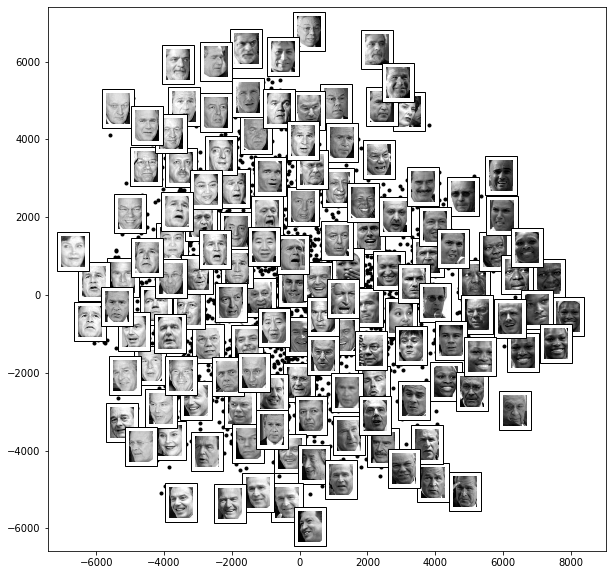

In [33]:
fig, ax = graph.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

# Example: Visualizing Structure in Digits

In [38]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

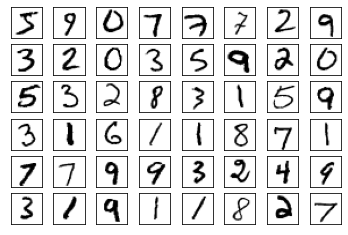

In [39]:
fig, ax = graph.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

In [43]:
print(graph.cm.get_cmap('jet', 10))

In [44]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

In [51]:
target.reshape(-1, 1)

array([['5'],
       ['3'],
       ['4'],
       ...,
       ['0'],
       ['4'],
       ['7']], dtype=object)

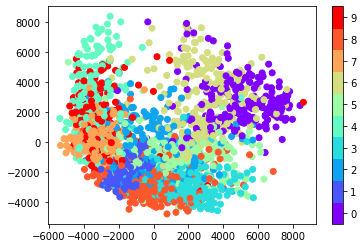

In [52]:
graph.scatter(proj[:, 0], proj[:, 1], c = target.reshape(-1, 1), cmap=graph.cm.get_cmap('rainbow', 10))
graph.colorbar(ticks=range(10))
graph.clim(-0.5, 9.5)

ValueError: Found array with 0 sample(s) (shape=(0, 784)) while a minimum of 1 is required.

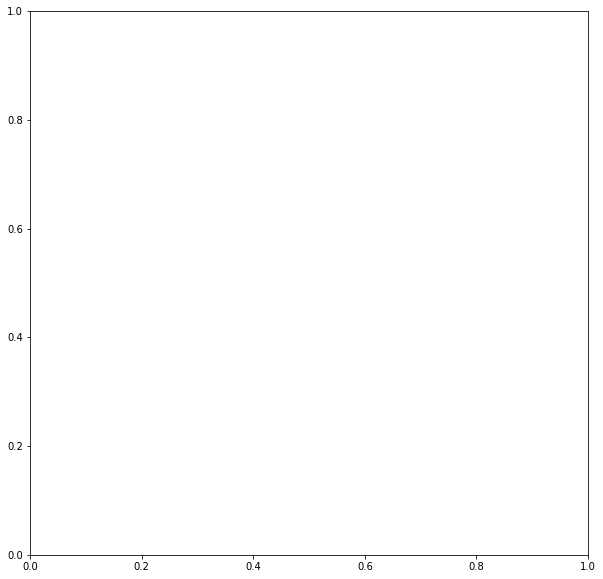

In [54]:
# Choose 1/4 of the "1" digits to project cause abvoe 
data = mnist.data[mnist.target == 1][::4]

fig, ax = graph.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')